In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy import signal
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import seaborn as sns

from datetime import date, datetime, timedelta
# from google.colab import files

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [15]:
# Read in weather data
weather = pd.read_csv('https://hydroeco.github.io/angelo/angelo_weather_1H.csv', parse_dates=True, index_col=0)
weather['waterYear']=np.where(~weather.index.month.isin([10,11,12]), weather.index.year, weather.index.year+1)
weather['WY_Rain_mm']=weather.groupby('waterYear')['AngeloMeadowWs_Rainfall_TB4'].cumsum()

dailyp= weather.groupby((pd.Grouper(freq='1D'))).sum()
monthlyp=dailyp.groupby((pd.Grouper(freq='1M'))).sum()
daily=weather.groupby((pd.Grouper(freq='1D'))).mean()
daily['Date'] =  pd.to_datetime((daily.index))
weather['Date'] =  pd.to_datetime((weather.index))
dailywyrain=weather.groupby((pd.Grouper(freq='1D'))).mean()
weatherwy=weather.groupby('waterYear').sum()
weatherwy

/var/folders/9h/qhym8j_x3vlby3c3j9klp0vc0000gn/T/ipykernel_2014/3143789574.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dailywyrain=weather.groupby((pd.Grouper(freq='1D'))).mean()
/var/folders/9h/qhym8j_x3vlby3c3j9klp0vc0000gn/T/ipykernel_2014/3143789574.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  weatherwy=weather.groupby('waterYear').sum()


,AngeloMeadowWs_Air_Temp,AngeloMeadowWs_Rainfall_TB4,AngeloMeadowWs_Relative_Humidity,AngeloMeadowWs_Total_Solar_Radiation,WY_Rain_mm
waterYear,,,,,
2016,93765.201167,2333.8,605064.458023,1.333354e+06,13967146.0
2017,101599.153282,3385.4,672139.028349,1.338015e+06,21292713.8
2018,94756.721871,1654.2,652378.352932,1.416087e+06,9740144.0
2019,98667.485750,2608.0,661422.197500,1.354294e+06,14462466.0
2020,100015.327994,1049.0,650887.082474,1.330602e+06,6279049.4
2021,99812.764803,1110.2,611404.531981,1.445467e+06,6709664.6
2022,86009.602955,601.4,603653.904428,1.257883e+06,3999920.8
2023,17133.851607,791.0,286340.263424,2.251421e+05,817313.0


In [16]:
from scipy.optimize import curve_fit
# Get TDT
# Read in rock moisture data
tdt = pd.read_csv('https://hydroeco.github.io/angelo/angelo_tdt_1H.csv', parse_dates=True, index_col=0)
tdt['Date'] =  pd.to_datetime((tdt.index))
tdt['Vms_Rock_Moisture_A5'] = np.where(tdt['Vms_Rock_Moisture_A5']<10,np.nan,tdt['Vms_Rock_Moisture_A5'])#.bfill()


TD = ''
for i in range(1,10):
  tdata = tdt[['Vms_Rock_Moisture_A'+str(i)]]
  key = 'A'+str(i)
  tdata = tdata.iloc[60*24:]
  tdata[key] = tdata['Vms_Rock_Moisture_A'+str(i)]#-tdata.value
  tdata['wy'] = np.where(tdata.index.month>9,tdata.index.year+1,
                        tdata.index.year)
  tdata = tdata.loc['2015-6-01':'2021-6-01']
  yrmins = tdata.groupby('wy').min()['Vms_Rock_Moisture_A'+str(i)]
  yrmindates = tdata.groupby('wy').idxmin()['Vms_Rock_Moisture_A'+str(i)]


  mindf = yrmins.rename('minval').reset_index().merge(yrmindates.rename('date').reset_index(),on='wy')
  tdata = tdata.reset_index().merge(mindf[['date','minval']],left_on='timestamp_local',right_on='date',how='left').drop(columns='date').set_index('timestamp_local')

  def func(x,a,b):
      return a*x+b
  popt,pcov = curve_fit(func,tdata.reset_index().dropna().index,tdata.dropna().minval,p0=(.01,20))
  tdata['adjust'] = func(tdata.reset_index().index,*popt)
  tdata['A'+str(i)] = tdata['A'+str(i)]-tdata.adjust

  tdata['A'+str(i)] = tdata['A'+str(i)]-tdata['A'+str(i)].min()
  tdata['A'+str(i)] = tdata['A'+str(i)]/tdata['A'+str(i)].max()


  if len(TD)==0:
      TD = tdata[key].to_frame()
  else:
      TD = TD.merge(tdata[key].to_frame(),left_index=True,right_index=True)
tdata = TD

In [17]:
# Get well data
wells = pd.read_csv('https://hydroeco.github.io/angelo/angelo_wells_1H.csv', parse_dates=True, index_col=0)
wells.drop(wells.tail(1).index,inplace=True)

url='https://drive.google.com/file/d/1fhoTlA2llDDxfVj1Cz9kO274Fm8gQQ8r/view?usp=sharing'
path='https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

well_data_filt=pd.read_csv(path,index_col=0,parse_dates=True)
well_data_filt.head()

,well_12_adjust,well_01_adjust,well_02_adjust,well_03_adjust,well_13_adjust,well_14_adjust,well_10_adjust,well_05_adjust,well_06_adjust,well_07_adjust,well_15_adjust,well_16_adjust,dayofyear,year
2011-02-09,-5.505280,-4.061302,-11.886732,-10.236680,-17.690118,-21.729315,-14.701872,-20.378381,-8.961212,-9.211434,-0.228720,-1.039351,40.0,2011
2011-02-10,-5.519537,-4.067069,-11.890667,-10.290903,-17.705201,-21.808227,-14.686601,-20.368826,-8.953399,-9.211527,-0.381072,-1.187110,41.0,2011
2011-02-11,-5.485716,-4.055828,-11.897586,-10.115298,-17.669201,-21.579570,-14.739558,-20.404798,-8.990221,-9.236937,-17.690565,-17.070992,42.0,2011
2011-02-12,-5.566386,-4.094531,-11.927416,-10.352328,-17.755559,-21.953479,-14.687788,-20.365392,-8.977613,-9.300656,-21.717251,-20.895108,43.0,2011
2011-02-13,-5.487742,-4.060476,-11.932615,-9.979930,-17.655029,-21.444613,-14.803650,-20.439809,-9.044919,-9.366765,-21.127419,-20.312703,44.0,2011


In [18]:
prismfull=pd.read_csv('https://raw.githubusercontent.com/evanking27/prismdata/main/prism%20(1).csv')
prismfull=prismfull.dropna(axis=0)
prismfull['Date'] = pd.to_datetime(prismfull['date'])
prismfull['date'] = pd.to_datetime(prismfull['date'])
prismfull=prismfull.set_index('Date')
prismfull['cWY_Rain_mm_riv']=prismfull.groupby('waterYear')['Rivendell'].cumsum()
prismwy=prismfull.groupby('waterYear').max()

#get 2022 prism weighted rain (broken gauge)
prism2022=pd.read_csv('https://raw.githubusercontent.com/evanking27/elderprism/main/weightedprism2022%20(5).csv')


In [19]:
# Read in isotope data
docID = '1T7q2lsuj6WuHQWK3pmsaWUvvrpKhIRDEif_1PM_jMPc' # after /d/ in url
gID = '477749500' # after gid= in url
isotopes = pd.read_csv('https://docs.google.com/spreadsheets/d/' + docID + '/export?gid=' + gID + '&format=csv')

isotopes['Time Collected'] = isotopes['Time Collected'].fillna('12:00')
isotopes['timestamp'] = isotopes['Date Collected'] + ' ' + isotopes['Time Collected']
isotopes['timestamp'] = pd.to_datetime(isotopes['timestamp'], errors='raise')
isotopes.index = isotopes['timestamp']
isotopes['timestamp_rounded'] = isotopes.index.round('H').copy()
isotopes = isotopes.drop(isotopes[isotopes.FLAG == 1].index) # remove flagged data
isotopes['waterYear']=np.where(~isotopes.index.month.isin([10,11,12]),
                             isotopes.index.year, isotopes.index.year+1)
VMS_isotopes = isotopes[isotopes['Sample Type II'] == 'VMS'] # create df of VMS isotopes
VMS_isotopes['dD'] = pd.to_numeric(VMS_isotopes['dD'])
precip_isotopes = isotopes[(isotopes['Sample Type II'] == 'Rain')&(isotopes['Site'] != 'Sagehorn')] # create df of Angelo precip isotopes
precip_isotopes['waterYear']=np.where(~precip_isotopes.index.month.isin([10,11,12]),
                             precip_isotopes.index.year, precip_isotopes.index.year+1)
precip_isotopes['dD'] = pd.to_numeric(precip_isotopes['dD'])
df=isotopes
solid_isotopes = df.loc[(df['Site']=='Rivendell') & (df['Sample Type']=='Soil or rock')]# & (df['Location']=='VMS1')|(df['Location']=='VMS2') ]

df['waterYear']=np.where(~df.index.month.isin([10,11,12]),
                             df.index.year, df.index.year+1)
df['Time Collected'] = df['Time Collected'].fillna('12:00')
df['date'] =  pd.to_datetime((df['Date Collected']))
df['datetime'] =  pd.to_datetime((df['Date Collected'] + ' ' + df['Time Collected']))
df.index = df['datetime']
df = df.drop(df[df.FLAG == 1].index)
df['month'] = pd.DatetimeIndex(df['datetime']).month
df['dayofyear'] = df['datetime'].dt.dayofyear

solid_isotopes.head()
s_iso=solid_isotopes.copy()

#soils = df.loc[(df['Site']=='Rivendell') & (df['Sample Type']=='Soil or rock')]# & (df['Location']=='VMS1')|(df['Location']=='VMS2') ]

soils = df.loc[(df['Site']=='Rivendell') & (df['Sample Type II']=='Lysimeter')]
trees = isotopes.loc[(df['Site']=='Rivendell') & (df['Sample Type']=='Tree')]

print(isotopes['Sample Type II'].unique())



/var/folders/9h/qhym8j_x3vlby3c3j9klp0vc0000gn/T/ipykernel_2014/167045190.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  VMS_isotopes['dD'] = pd.to_numeric(VMS_isotopes['dD'])
/var/folders/9h/qhym8j_x3vlby3c3j9klp0vc0000gn/T/ipykernel_2014/167045190.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precip_isotopes['waterYear']=np.where(~precip_isotopes.index.month.isin([10,11,12]),
/var/folders/9h/qhym8j_x3vlby3c3j9klp0vc0000gn/T/ipykernel_2014/167045190.py:19: SettingWithCopyWarning: 
A value is t

['Stream water' 'Leaf' 'Surface soil' 'Tree core' 'Stem' 'Rain' 'Well'
 'Water tank' 'Drilled material' 'DI water' 'Snow' 'VMS' nan 'Spring'
 'Lysimeter' 'Stream Water' 'Soil' 'Hand Sample' 'Saprolite' 'Field Blank'
 'Transpired H2O' 'Blank' 'Stream' 'Stream ' 'Tree stem']


In [20]:
# Configure VMS samples
selected_columns = VMS_isotopes[["Date Collected","Location", "dD", "dO"]]
new_df = selected_columns.copy()
new_df['date'] =  pd.to_datetime((new_df['Date Collected']))

# Assign all dates a depth
new_df['Mydepth'] = new_df['Location']
new_df['Mydepth'] = new_df['Mydepth'].replace(['A1'],1.95)
new_df['Mydepth'] = new_df['Mydepth'].replace(['A2'],3.64)
new_df['Mydepth'] = new_df['Mydepth'].replace(['A3'],5.22)
new_df['Mydepth'] = new_df['Mydepth'].replace(['A4'],6.88)
new_df['Mydepth'] = new_df['Mydepth'].replace(['A5'],8.49)
new_df['Mydepth'] = new_df['Mydepth'].replace(['A6'],10.16)
new_df['Mydepth'] = new_df['Mydepth'].replace(['A7'],11.89)
new_df['Mydepth'] = new_df['Mydepth'].replace(['A8'],13.33)
new_df['Mydepth'] = new_df['Mydepth'].replace(['A9'],14.89)
new_df['Mydepth'] = new_df['Mydepth'].replace(['A10'],16.55)
new_df['Mydepth'] = new_df['Mydepth'].replace(['B1'],1.39)
new_df['Mydepth'] = new_df['Mydepth'].replace(['B1 '],1.39)
new_df['Mydepth'] = new_df['Mydepth'].replace(['B2'],3.00)
new_df['Mydepth'] = new_df['Mydepth'].replace(['B3'],4.54)
new_df['Mydepth'] = new_df['Mydepth'].replace(['B4'],6.12)
new_df['Mydepth'] = new_df['Mydepth'].replace(['B5'],7.72)
new_df['Mydepth'] = new_df['Mydepth'].replace(['B6'],9.31)
new_df['Mydepth'] = new_df['Mydepth'].replace(['B7'],10.78)
new_df['Mydepth'] = new_df['Mydepth'].replace(['B8'],12.2)
new_df['Mydepth'] = new_df['Mydepth'].replace(['B9'],13.65)
new_df['Mydepth'] = new_df['Mydepth'].replace(['B10'],15.31)

new_df['waterYear']=np.where(~new_df.index.month.isin([10,11,12]), new_df.index.year, new_df.index.year+1)


In [21]:
new_df.columns

Index(['Date Collected', 'Location', 'dD', 'dO', 'date', 'Mydepth',
       'waterYear'],
      dtype='object')

In [22]:
tdt_daily_norm = TD.resample('D').median().interpolate()

In [23]:
pet = pd.read_csv('../Data/pet_data_frompeter.csv').rename(columns={'Air Temp WSAM [Angelo Meadow WS]':
                                                               'PET_mmd'})
pet['Timestamp'] = pd.to_datetime(pet.Timestamp)
pet.set_index('Timestamp',inplace=True)
pet['PET_mmd'] = pet.PET_mmd*24
pet = pet.resample('D').mean()

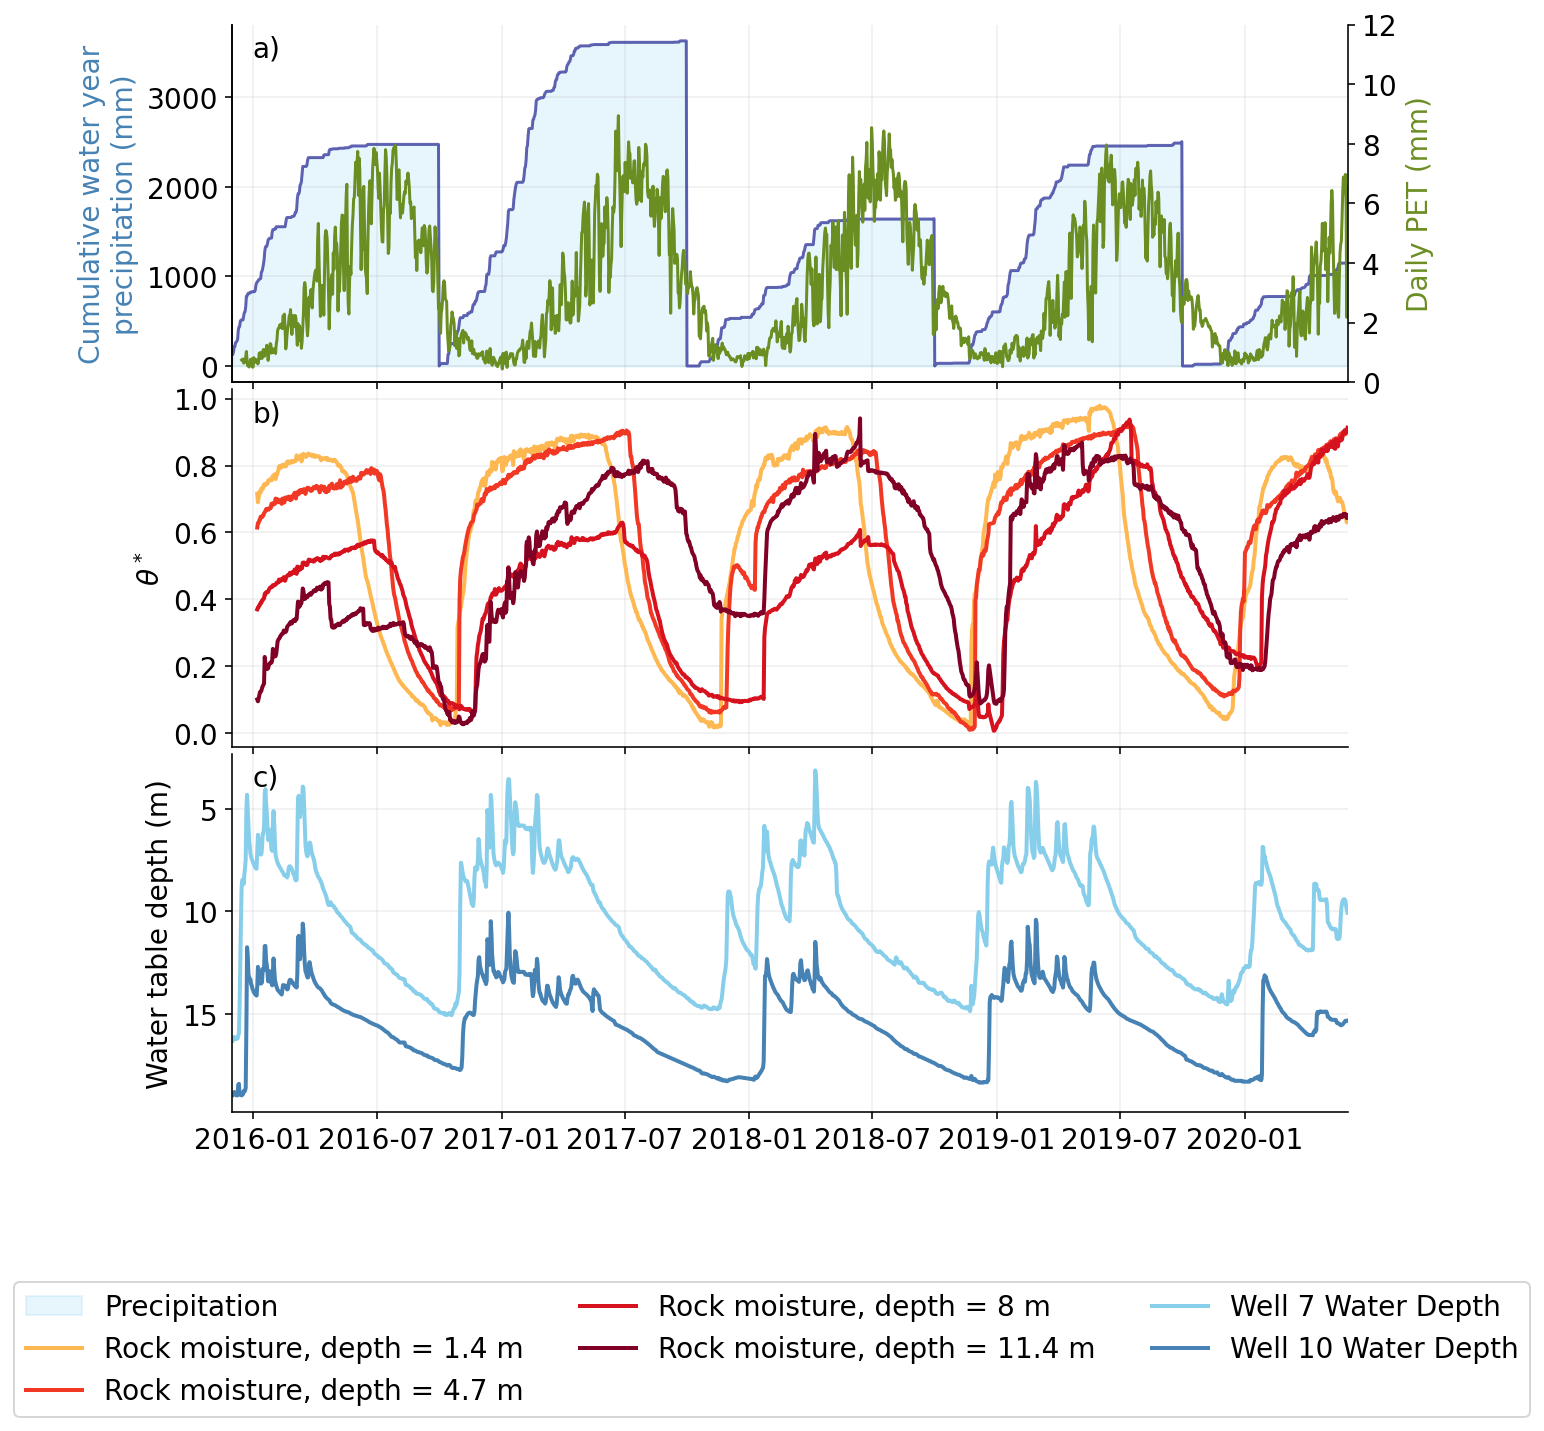

In [11]:
import matplotlib.transforms as mtransforms

#@title Stacked plot: Rock moisture, well levels, precipitation
import matplotlib.pylab as pl
plt.rcParams['font.size'] = 14
aports = ['A1', 'A2', 'A3','A4', 'A5', 'A6','A7']
asensors = [1.4, 2.9, 4.7, 6.4, 8, 9.7, 11.4]
colors = pl.cm.YlOrRd(np.linspace(0.25,1,7+1))
#aports = ['A1', 'A5']
#asensors = [1.4,8]

date_start = '12-1-2015'
date_end = '6-1-2020'#well_data_filt.index[-1]
prismfullnew= prismfull.loc[(prismfull['date'] < date_end)& (prismfull['date'] > date_start)]
tdt_dates = tdt_daily_norm.loc[(tdt_daily_norm.index < date_end)& (tdt_daily_norm.index > date_start)]
welldates = well_data_filt.loc[(well_data_filt.index < date_end)& (well_data_filt.index > date_start)]
plt.rcParams["figure.facecolor"] = 'w'

fig, ax = plt.subplots(3,1, sharex=True, sharey= False,figsize=(10,10))
ax[0].grid(alpha=0.2)
ax[0].grid(True)

ax[0].plot(prismfullnew.index, prismfullnew['Rivendell_WY_Rain_mm'],color="navy",alpha=0.6)
pre = ax[0].fill_between(prismfullnew.index, prismfullnew['Rivendell_WY_Rain_mm'],label = 'Precipitation', color="#89CFF0",alpha=0.2)
ax[0].set_ylabel('Cumulative water year\nprecipitation (mm)',c='steelblue')
#ax[0].get_yaxis().set_ticks([0,400,800,1200])
ax[0].tick_params('x', labelbottom=False)
ax1 = ax[0].twinx()
ax1.plot(pet,c='olivedrab')
ax1.set_ylim(0,12)
ax1.set_ylabel('Daily PET (mm)',c='olivedrab')


# ax2 = ax[0].twinx()


lw=2
r1, = ax[1].plot(tdt_dates.index, tdt_dates['A1'], color=colors[1],label = 'Rock moisture, depth = 1.4 m',lw=lw)
r2, = ax[1].plot(tdt_dates.index, tdt_dates['A4'], color=colors[4], label = 'Rock moisture, depth = 4.7 m',lw=lw)
r3, = ax[1].plot(tdt_dates.index, tdt_dates['A5'], color=colors[5], label = 'Rock moisture, depth = 8 m',lw=lw)
r4, = ax[1].plot(tdt_dates.index, tdt_dates['A7'], color=colors[7],label = 'Rock moisture, depth = 11.4 m',lw=lw)

ax[1].grid(alpha=0.2)
ax[1].set_ylabel(r'$\theta^*$')
ax[1].set_xlim(pd.to_datetime(date_start), pd.to_datetime(date_end))

w10, = ax[2].plot(welldates.index, welldates['well_10_adjust']*-1, color='steelblue', linewidth=2, label='Well 10 Water Depth')
w7, = ax[2].plot(welldates.index, welldates['well_07_adjust']*-1, color='skyblue', linewidth=2, label='Well 7 Water Depth')

# d1 = pd.to_datetime('12-01-2019')
# d2 = pd.to_datetime('03-01-2020')
# wet = ax[1].axvspan(d1,d2, facecolor='#FFF01F', alpha=0.3, label ='Example of\nprogressive wetting')

# d1 = pd.to_datetime('07-01-2020')
# d2 = pd.to_datetime('10-01-2020')
# dry = ax[1].axvspan(d1,d2, facecolor='#39FF14', alpha=0.3, label ='Example of\nprogressive drying')

# ax[0].text(x= pd.to_datetime('11-01-2018'), y=2250, s='A', fontsize=18,fontweight='bold')
# ax[1].text(x= pd.to_datetime('11-01-2018'), y=0.9, s='B', fontsize=18,fontweight='bold')
# ax[2].text(x= pd.to_datetime('11-01-2018'), y=4.5, s='C', fontsize=18,fontweight='bold')

ax[2].invert_yaxis()
ax[2].grid(True, alpha=0.2)
ax[2].set_ylabel('Water table depth (m)')

#plt.legend(loc= 'center',bbox_to_anchor=(0.5, -0.42), ncol= 3,facecolor='white', framealpha=1)
plt.xticks(rotation=45)
plt.subplots_adjust(hspace=0.02)

items = [pre, r1, r2, r3, r4, w7, w10]
fig.legend(items, [item.get_label() for item in items],loc= 'center', bbox_to_anchor=(0.5, -0.04), ncol= 3)


labels = ['a)','b)','c)','d)','e)','f)','g)','h)','i)',
         'j)','k)','l)','m)','n)','o)','p)','q)','r)',
          's)','t)','u)','v)']
for i,ax2 in enumerate(ax.flatten()):
    for side in ['top','right']:
        ax2.spines[side].set_visible(False)

    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax2.text(0, 1, labels[i], transform=ax2.transAxes + trans,
             verticalalignment='top', )
ax1.spines['top'].set_visible(False)

plt.savefig('datafig_vms.png',format='png',dpi=300,bbox_inches='tight')